In [1]:
from dotenv import load_dotenv
load_dotenv()

%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

UsageError: Line magic function `%%capture` not found.


In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults
from typing import Annotated, TypedDict
import operator
from langgraph.graph import StateGraph, START, END

In [8]:
# Initialize model
llm = ChatOpenAI(model="gpt-4o", temperature=0)


# Define the graph state
class State(TypedDict):
    company: str
    summary: str
    context: Annotated[list, operator.add]


In [9]:
# Node 1: Search for recent news
def search_news(state):
    """Retrieve recent tech news about the company."""
    company = state["company"]
    tavily = TavilySearchResults(max_results=3)
    search_docs = tavily.invoke(f"Recent news about {company}")

    formatted_docs = "\n\n---\n\n".join(
        [f"<News href='{doc['url']}'>\n{doc['content']}\n</News>" for doc in search_docs]
    )
    return {"context": [formatted_docs]}

# Node 2: Get Wikipedia background
def search_background(state):
    """Retrieve company background from Wikipedia."""
    company = state["company"]
    search_docs = WikipediaLoader(query=company, load_max_docs=1).load()

    formatted_docs = "\n\n---\n\n".join(
        [f"<Wikipedia source='{doc.metadata['source']}'>\n{doc.page_content}\n</Wikipedia>" for doc in search_docs]
    )
    return {"context": [formatted_docs]}

# Node 3: Summarize everything
def summarize_news(state):
    """Generate a summary of recent news and background."""
    company = state["company"]
    context = "\n\n".join(state["context"])

    prompt = f"""
    Summarize the most recent developments about {company} using this information:
    {context}

    Your summary should include:
    - 3–5 key highlights or events.
    - Mention stock or tech updates if present.
    - Write in 2–3 clear, concise paragraphs.
    """

    response = llm.invoke(prompt)
    return {"summary": response.content}


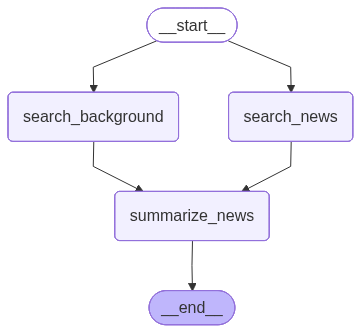

In [10]:
builder = StateGraph(State)

builder.add_node("search_news", search_news)
builder.add_node("search_background", search_background)
builder.add_node("summarize_news", summarize_news)

# Define flow
builder.add_edge(START, "search_news")
builder.add_edge(START, "search_background")
builder.add_edge("search_news", "summarize_news")
builder.add_edge("search_background", "summarize_news")
builder.add_edge("summarize_news", END)

# Compile the graph
graph = builder.compile()

# Visualize the flow
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
result = graph.invoke({"company": "Apple"})
print(result["summary"])


In the latest developments, Apple reported a total revenue of $416 billion for fiscal 2025, marking a 6% increase over the previous year. The company's sales in the September quarter rose by 8% annually, driven by the launch of the iPhone 17, which contributed to a 6% increase in iPhone revenue, totaling $49.03 billion. Despite these gains, Apple shares experienced a decline due to iPhone revenue missing expectations. The Mac business, however, showed robust growth with a 13% increase in sales, attributed to the strong performance of the MacBook Air, which saw a price reduction earlier in the year.

In terms of geographical performance, Apple's sales in Greater China, including Hong Kong and Taiwan, fell by 4% annually to $14.5 billion. However, CEO Tim Cook expressed optimism about a return to growth in the region, citing positive reception of the iPhone 17. Looking ahead, Apple plans to release an updated version of Siri next year and is exploring further partnerships, such as integr